In [1]:
import csv
import yaml
import json
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from collections import namedtuple
from scipy.stats import t as studentt
from scipy.stats import binomtest

In [2]:
class CentralLimitTheoremT:
    def __init__(self, error_rate):
        self.error_rate = error_rate

    def p(self, n, sample_mean, mean, stddev):
        y = np.sqrt(n) * (sample_mean - mean) / stddev
        return studentt.cdf(y, n-1)

    def confidence_interval(self, n, stddev):
        s = stddev / np.sqrt(n)
        delta = studentt.ppf(1.0 - self.error_rate / 2, n-1) * s
        return delta
    

def maxComparisonPerPair(epsilon, delta):
    epsilon2 = epsilon * epsilon
    m = int(np.ceil(0.5 / epsilon2 * np.log(2.0 / delta)))
    return m

epsilon = 0.1013
delta = 0.05
cltt = CentralLimitTheoremT(delta)
max_eval = maxComparisonPerPair(epsilon, delta)
print(max_eval)

def fontcolor(v, vmax):
    if (v / vmax > 0.8):
        return 'black'
    else:
        return 'white'

180


In [3]:
with open("test_score-X0VJzx6LqO8b.json", mode='r') as f:
    score_results = json.load(f)
with open("merge_ranks.json", mode='r') as f:
    results = json.load(f)
with open("definition.yml", mode='r') as f:
    definition = yaml.safe_load(f)
    
commands = results["result"]["experimental_manifests"][0]["compare_commands"]
systems_ranked = results['result']['experimental_manifests'][0]['merge_rank']['s_merged']
abbs = definition['experiment']['manifests'][0]['system_abbreviations']
systems_abb = {item['system_name']: item['abbreviation'] for item in abbs}

In [4]:
systems = list(reversed(systems_ranked))
system_to_index = {s: i for i, s in enumerate(systems)}

In [5]:
result_map_tmp = np.zeros((len(systems), len(systems)), dtype=np.int32)
for r in commands:
    result_map_tmp[system_to_index[r["system_j"]], system_to_index[r["system_i"]]] = r["n_results"]

In [6]:
def gen_pairs():
    for i in reversed(range(len(systems))):
        for j in reversed(range(len(systems))):
            if (result_map_tmp[i, j] == 0):
                pass
            else:
                yield (systems[j],systems[i])

system_pairs = list(gen_pairs())

In [7]:
print(len(systems))
print(len(system_pairs))

15
32


In [8]:
def confint(n):
    delta = 0.05
    a = np.log(4 * n * n) - np.log(delta)
    b = a / n * 0.5
    c = np.sqrt(b)
    return c

def confint_Hoeffding(n):
    delta = 0.05
    a = np.log(2.0) - np.log(delta)
    b = a / n * 0.5
    c = np.sqrt(b)
    return c

def confint_studentt(n, stddev):
    return cltt.confidence_interval(n, stddev)

def epsilon_Hoeffding(p, n):
    e = confint_Hoeffding(n) - np.abs(p - 0.5)
    return e

def find_significance(pair_data):
    scores = np.array([v["score_value"] for v in pair_data])
    score = np.mean(scores)
    stddev = np.std(scores)
    cis = confint_studentt(n_results, stddev)
    eps = cis - np.abs(score - 0.5)
    if eps <= 0.0:
        return 1
    else:
        return 0

In [9]:
n_results_list = []
result_map = np.zeros((len(systems), len(systems)), dtype=np.int32)
epsilon_map = np.zeros((len(systems), len(systems)), dtype=np.float32)
epsilonh_map = np.zeros((len(systems), len(systems)), dtype=np.float32)
score_map = np.zeros((len(systems), len(systems)), dtype=np.float32)
pvalue_map = np.zeros((len(systems), len(systems)), dtype=np.float32)
significant_map = np.zeros((len(systems), len(systems)), dtype=np.int32)
nonsignificant_map = np.zeros((len(systems), len(systems)), dtype=np.int32)
for pair in system_pairs:
    pair_data = [s for s in score_results["result"]["scores"] if s["samples"]["sample_i"]["system"]["abbreviation"] == pair[0] and s["samples"]["sample_j"]["system"]["abbreviation"] == pair[1]]
    n_results = len(pair_data)
    n_results_list.append(n_results)
    total_value = sum([v["score_value"] for v in pair_data])
    score = total_value / n_results
    ci = confint(n_results)
    cih = confint_Hoeffding(n_results)
    stddev = np.std(np.array([v["score_value"] for v in pair_data]))
    cis = confint_studentt(n_results, stddev)
    ep = ci - np.abs(score - 0.5)
    eph = cih - np.abs(score - 0.5)
    system_i = pair[0]
    system_j = pair[1]
    result_map[system_to_index[system_j], system_to_index[system_i]] = n_results
    epsilon_map[system_to_index[system_j], system_to_index[system_i]] = ep
    epsilonh_map[system_to_index[system_j], system_to_index[system_i]] = eph
    score_map[system_to_index[system_j], system_to_index[system_i]] = score
    if score > 0.5:
        method = 'greater'
    else:
        method = 'less'
    test_result = binomtest(total_value, n_results, p=0.5, alternative=method)
    pvalue_map[system_to_index[system_j], system_to_index[system_i]] = test_result.pvalue
    significant_map[system_to_index[system_j], system_to_index[system_i]] = int(test_result.pvalue <= 0.05)
    nonsignificant_map[system_to_index[system_j], system_to_index[system_i]] = int(test_result.pvalue > 0.05)

In [10]:
print(len(n_results_list))
print(min(n_results_list))
print(max(n_results_list))

32
21
964


In [11]:
print("Pair $(i:j)$&$r_{ij}$&$p_{ij}$&$\hat{c}$&$\hat{c}_{\mathrm{Hoeffding}}$&$\hat{c}_{\mathrm{Student-t}}$&$\hat{\epsilon}$&$\hat{\epsilon}_{\mathrm{Hoeffding}}$&$\hat{\epsilon}_{\mathrm{Student-t}}$\\\\\\hline")
for pair in system_pairs:
    pair_data = [s for s in score_results["result"]["scores"] if s["samples"]["sample_i"]["system"]["abbreviation"] == pair[0] and s["samples"]["sample_j"]["system"]["abbreviation"] == pair[1]]
    n_results = len(pair_data)
    total_value = sum([v["score_value"] for v in pair_data])
    score = total_value / n_results
    ci = confint(n_results)
    cih = confint_Hoeffding(n_results)
    stddev = np.std(np.array([v["score_value"] for v in pair_data]))
    cis = confint_studentt(n_results, stddev)
    ep = ci - np.abs(score - 0.5)
    eph = cih - np.abs(score - 0.5)
    eps = cis - np.abs(score - 0.5)
    system_i = pair[0]
    system_j = pair[1]
    pair_name = f"{system_i}:{system_j}"
    print(f"{system_i}:{system_j}&{n_results}&{score:.2f}&{ci:.2f}&{cih:.2f}&{cis:.2f}&{ep:.2f}&{eph:.2f}&{eps:.2f}\\\\")

Pair $(i:j)$&$r_{ij}$&$p_{ij}$&$\hat{c}$&$\hat{c}_{\mathrm{Hoeffding}}$&$\hat{c}_{\mathrm{Student-t}}$&$\hat{\epsilon}$&$\hat{\epsilon}_{\mathrm{Hoeffding}}$&$\hat{\epsilon}_{\mathrm{Student-t}}$\\\hline
ORI:S45G1&453&0.57&0.14&0.06&0.05&0.07&-0.01&-0.02\\
S45G1:S35G1&58&0.78&0.33&0.18&0.11&0.05&-0.10&-0.17\\
ORI:S25G1&44&0.91&0.37&0.20&0.09&-0.04&-0.20&-0.32\\
S45G1:S25G1&49&0.80&0.35&0.19&0.12&0.06&-0.10&-0.18\\
S35G1:S25G1&59&0.76&0.33&0.18&0.11&0.06&-0.09&-0.15\\
S25G1:S25G3&98&0.70&0.26&0.14&0.09&0.06&-0.07&-0.11\\
S25G1:S25G6&67&0.75&0.31&0.17&0.11&0.06&-0.08&-0.14\\
S25G3:S25G6&140&0.69&0.23&0.11&0.08&0.03&-0.08&-0.12\\
S15G3:S25G6&910&0.47&0.10&0.05&0.03&0.07&0.01&0.00\\
ORI:S15G6&101&0.95&0.26&0.14&0.04&-0.19&-0.32&-0.41\\
S45G1:S15G6&108&0.95&0.25&0.13&0.04&-0.20&-0.32&-0.41\\
S35G1:S15G6&99&0.98&0.26&0.14&0.03&-0.22&-0.34&-0.45\\
S25G1:S15G6&88&0.93&0.28&0.14&0.05&-0.16&-0.29&-0.38\\
S25G3:S15G6&106&0.92&0.25&0.13&0.05&-0.17&-0.29&-0.37\\
S25G6:S15G6&165&0.67&0.21&0.11&0.07&

In [12]:
significance_list = []
for pair in system_pairs:
    pair_data = [s for s in score_results["result"]["scores"] if s["samples"]["sample_i"]["system"]["abbreviation"] == pair[0] and s["samples"]["sample_j"]["system"]["abbreviation"] == pair[1]]
    significance_list.append(find_significance(pair_data))
sum(significance_list)

27

In [13]:
def score_history(scores):
    total = 0
    n_results = 0
    sorted_scores = sorted(scores, key=lambda s: datetime.fromisoformat(s["created_at"].replace('Z[GMT]','')))
    for s in sorted_scores:
        total += s["score_value"]
        n_results += 1
        score = total / n_results
        created_at = datetime.fromisoformat(s["created_at"].replace('Z[GMT]',''))
        yield (n_results, score, confint(n_results), confint_Hoeffding(n_results), created_at)
        
def extract(vs, i):
    return np.array([v[i] for v in vs])

def find_significant_point(scores):
    for s in scores:
        if s[2] - np.abs(s[1] - 0.5) < epsilon:
            return s[0]
    return -1

def find_significant_point_and_score(scores):
    for s in scores:
        if s[2] - np.abs(s[1] - 0.5) < epsilon:
            return s[0], s[1]
        elif s[0] == max_eval:
            return s[0], s[1]
    return -1

def find_significant_point_h(scores):
    for s in scores:
        if s[3] - np.abs(s[1] - 0.5) < epsilon:
            return s[0]
    return -1

def find_winner_flip(scores, max_eval, pair):
    score = None
    n = -1
    for s in scores:
        if s[2] - np.abs(s[1] - 0.5) <= epsilon:
            if score is None:
                score = s[1]
                n = s[0]
        if s[0] == max_eval:
            if score is None:
                score = s[1]
                n = s[0]
    final_score = s[1]
    final_n = s[0]
    if score is None:
        print(f"{pair} is not converged. {s[2] - np.abs(s[1] - 0.5)} > {epsilon} and {s[0]} < {max_eval}")
        return False, score, final_score
    else:
        if np.sign(score - 0.5) == np.sign(final_score - 0.5):
            return False, score, final_score, n, final_n
        else:
            return True, score, final_score, n, final_n

Flip is detected. S5G6:S5G11 0.4888888888888889 0.5305263157894737 180 950
Flip is detected. S5G6:S5G13 0.49444444444444446 0.5336322869955157 180 892
Flip is detected. S5G6:S5G16 0.5 0.5376078914919852 180 811


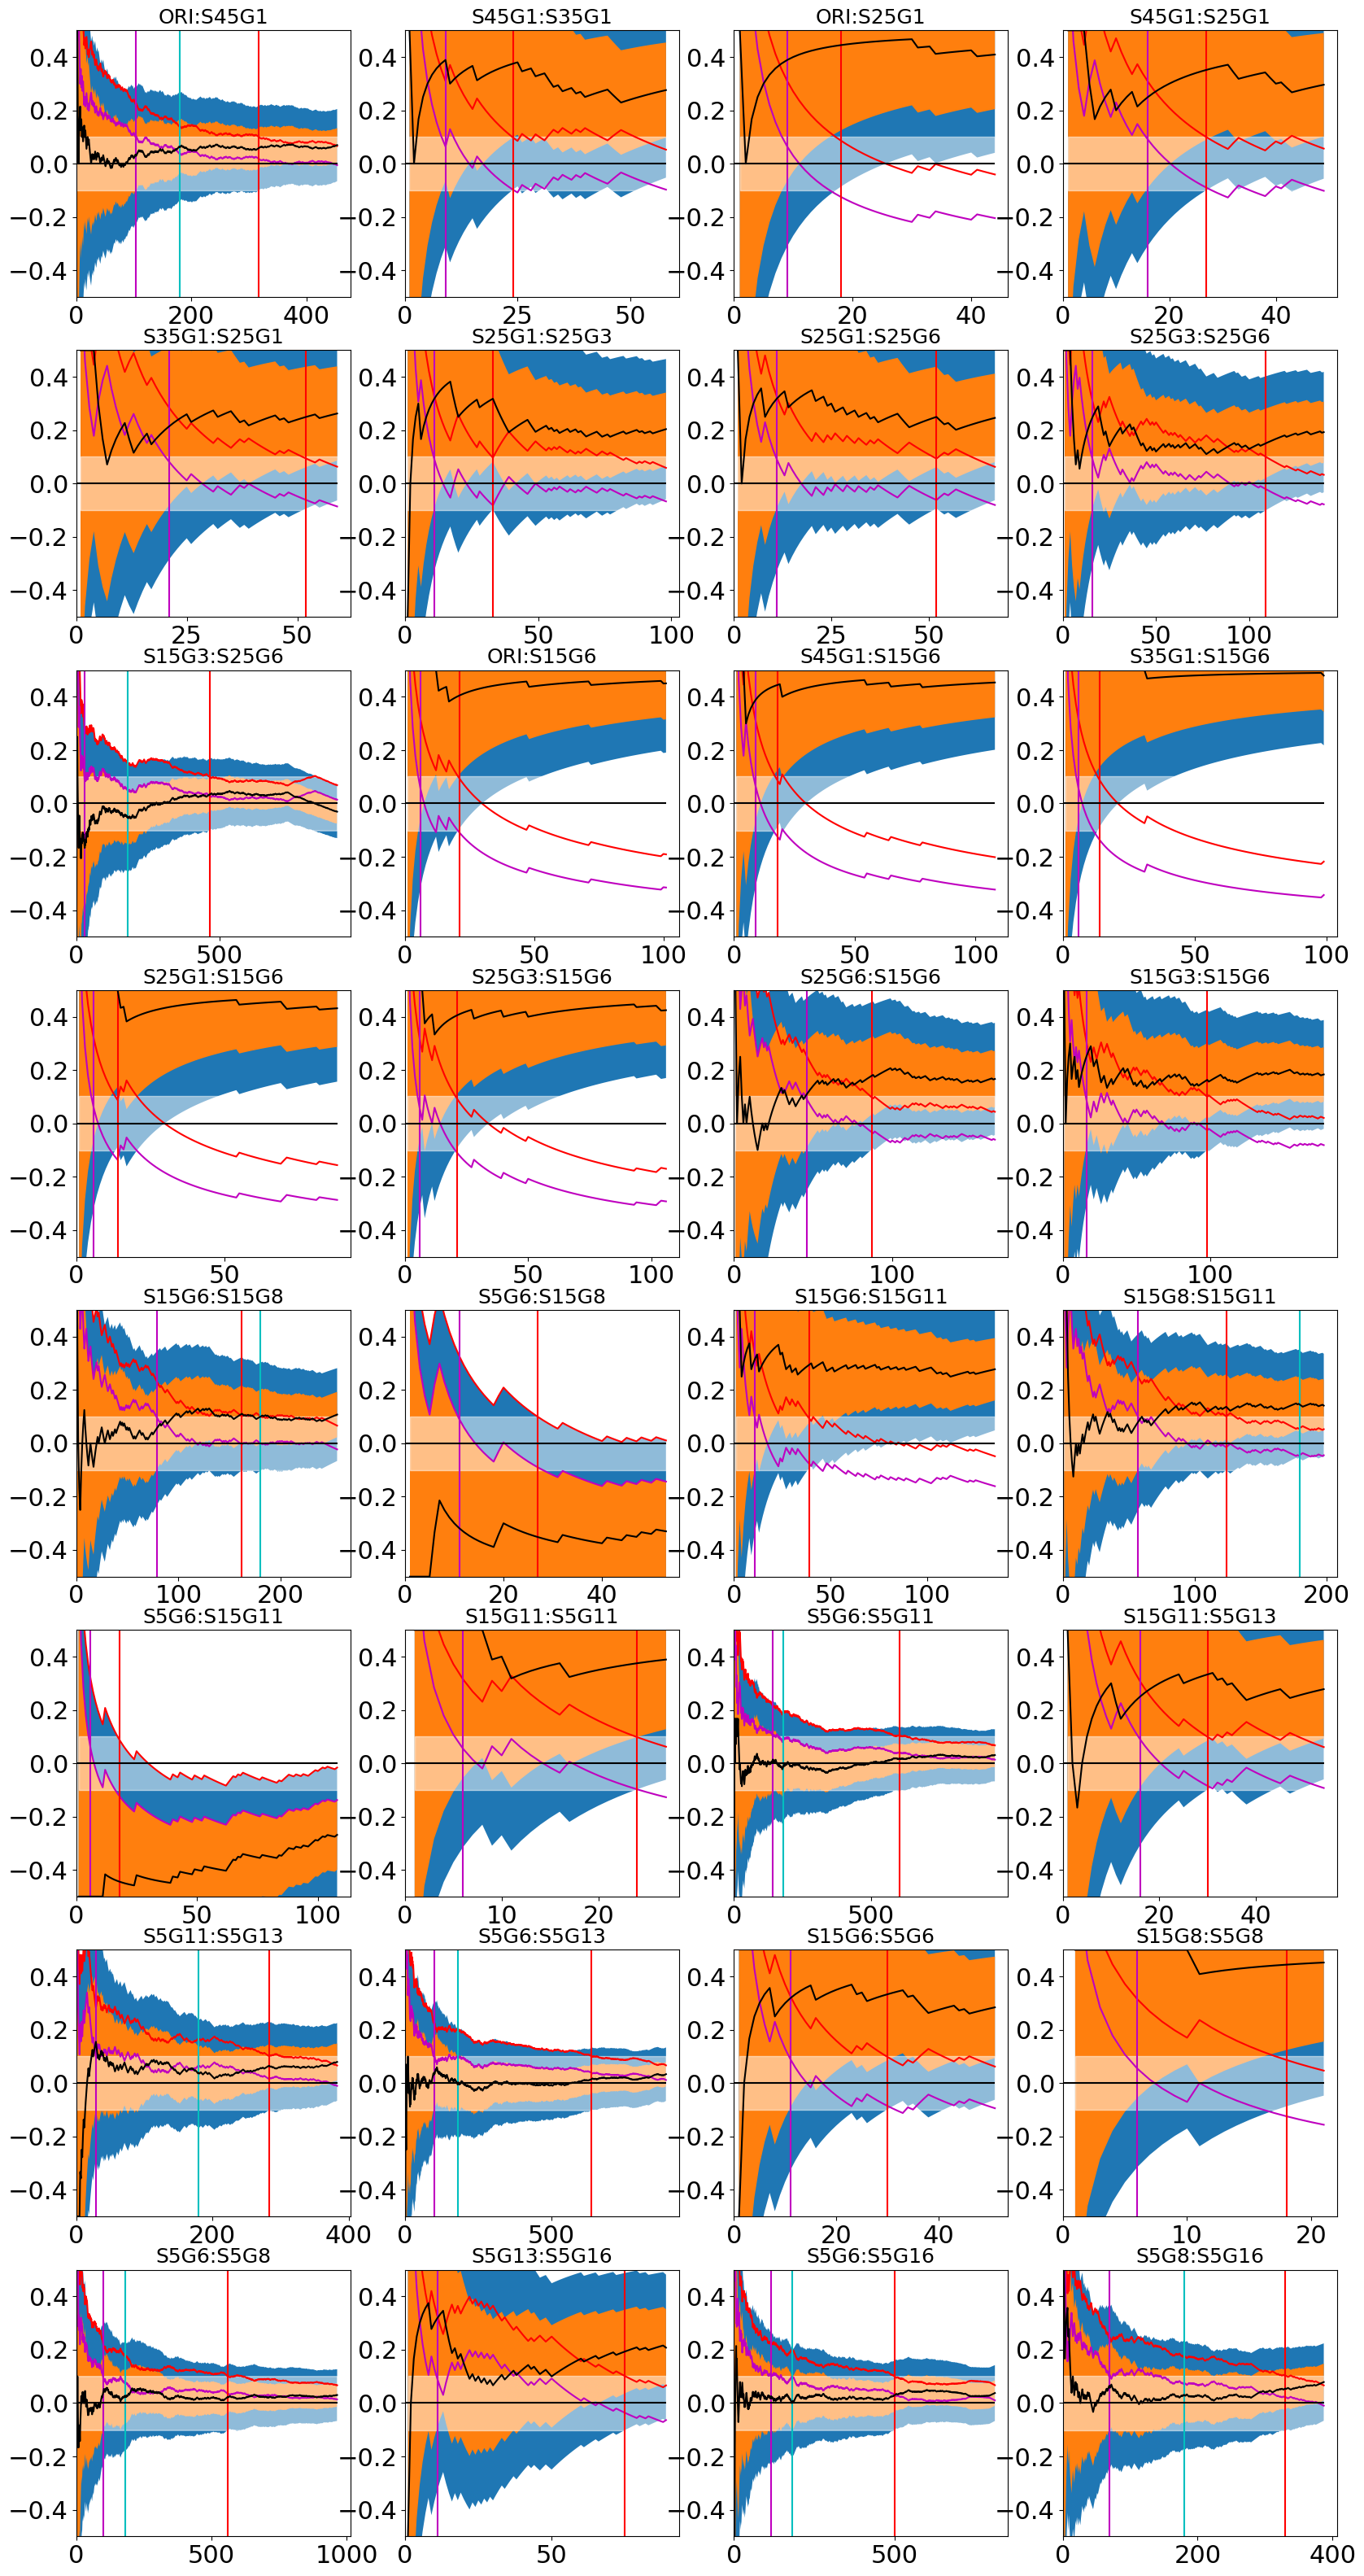

In [14]:
max_termination = []
early_termination = []
plt.rcParams.update({'font.size': 22})
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(20, 40))
for i, (pair, ax) in enumerate(zip(system_pairs, axs.flatten())):
    pair_data = [s for s in score_results["result"]["scores"] if s["samples"]["sample_i"]["system"]["abbreviation"] == pair[0] and s["samples"]["sample_j"]["system"]["abbreviation"] == pair[1]]
    score_data = list(score_history(pair_data))
    score = extract(score_data, 1)
    score_center = extract(score_data, 1) - 0.5
    ns = extract(score_data, 0)
    ci = extract(score_data, 2)
    cih = extract(score_data, 3)
    sn = find_significant_point(score_data)
    snh = find_significant_point_h(score_data)
    ax.fill_between(ns, score_center - ci, score_center + ci, label='MergeRank', zorder=0.1)
    ax.fill_between(ns, score_center - cih, score_center + cih, label='Hoeffding', zorder=0.2)
    ax.fill_between(ns, -epsilon, epsilon, color='white', alpha=0.5, label='Epsilon', zorder=0.3)
    ax.plot(ns, score_center, color='black', label='Mean', zorder=0.7)
    ax.plot(ns, ci - np.abs(score_center), color='red', label='Epsilon', zorder=0.6)
    ax.plot(ns, cih - np.abs(score_center), color='m', label='Epsilon2', zorder=0.6)
    ax.vlines(sn, -0.5, 0.5, color='red', label='Significant', zorder=0.6)
    ax.vlines(snh, -0.5, 0.5, color='m', label='Significant', zorder=0.6)
    if ns[-1] >= max_eval:
        ax.vlines(max_eval, -0.5, 0.5, color='c', label='Max', zorder=0.6)
    ax.hlines(0, 0, len(ns), color='black', label='Even', zorder=0.6)
    system_i = pair[0]
    system_j = pair[1]
    if sn == -1 or sn >= max_eval:
        max_termination.append(f"{system_i}:{system_j}")
    else:
        early_termination.append(f"{system_i}:{system_j}")
#     plt.legend()
    ax.set_xlim(0)
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"{system_i}:{system_j}", fontsize=18)
    is_flip, significant_score, final_score, significant_n, final_n = find_winner_flip(score_data, max_eval, f"{pair[0]}:{pair[1]}")
    if is_flip:
        print("Flip is detected.", f"{pair[0]}:{pair[1]}", significant_score, final_score, significant_n, final_n)
#     plt.xlabel('N')
#     plt.ylabel('Preference')
fig.savefig('score_history.pdf', bbox_inches="tight")
fig.savefig('score_history.png', bbox_inches="tight")

In [15]:
print(len(max_termination))
print(len(early_termination))

8
24


In [16]:
sns = []
print("Pair $(i:j)$&$r_{ij}$&$p_{ij}$&$\hat{c}$&$\hat{c}_{\mathrm{Hoeffding}}$&$\hat{c}_{\mathrm{Student-t}}$&$\hat{\epsilon}$&$\hat{\epsilon}_{\mathrm{Hoeffding}}$&$\hat{\epsilon}_{\mathrm{Student-t}}$\\\\\\hline")
for pair in system_pairs:
    pair_data = [s for s in score_results["result"]["scores"] if s["samples"]["sample_i"]["system"]["abbreviation"] == pair[0] and s["samples"]["sample_j"]["system"]["abbreviation"] == pair[1]]
    score_data = list(score_history(pair_data))
    sn, sp = find_significant_point_and_score(score_data)
    n_results = len(pair_data)
    total_value = sum([v["score_value"] for v in pair_data])
    score = total_value / n_results
    ci = confint(n_results)
    cih = confint_Hoeffding(n_results)
    stddev = np.std(np.array([v["score_value"] for v in pair_data]))
    cis = confint_studentt(n_results, stddev)
    ep = ci - np.abs(score - 0.5)
    eph = cih - np.abs(score - 0.5)
    eps = cis - np.abs(score - 0.5)
    system_i = pair[0]
    system_j = pair[1]
    pair_name = f"{system_i}:{system_j}"
    if score > 0.5:
        method = 'greater'
    else:
        method = 'less'
    test_result = binomtest(total_value, n_results, p=0.5, alternative=method)
    sig_sign = "*" if test_result.pvalue <= 0.05 else ""
    if pair_name in max_termination:
        pair_name = "\cellcolor{cyan!25}" + f"{system_i}:{system_j}{sig_sign}"
        ci = f"{ci:.2f}"
        ep = f"{ep:.2f}"
        cih = "\cellcolor{cyan!25}" + f"{cih:.2f}"
        eph = "\cellcolor{cyan!25}" + f"{eph:.2f}"
    if pair_name in early_termination:
        pair_name = "\cellcolor{red!25}" + f"{system_i}:{system_j}{sig_sign}"
        ci = "\cellcolor{red!25}" + f"{ci:.2f}"
        ep = "\cellcolor{red!25}" + f"{ep:.2f}"
        cih = f"{cih:.2f}"
        eph = f"{eph:.2f}"
    if sn == -1:
        sn = max_eval
    sns.append(sn)
    if np.sign(sp - 0.5) != np.sign(score - 0.5):
        score = "\cellcolor{yellow!25}" + f"{score:.2f}"
        sp = "\cellcolor{yellow!25}" + f"{sp:.2f}"
    else:
        score = f"{score:.2f}"
        sp = f"{sp:.2f}"
    
#     print(f"{system_i}:{system_j}&{n_results}&{score:.2f}&{ci}&{cih}&{cis:.2f}&{ep}&{eph}&{eps:.2f}\\\\")
    print(f"{pair_name}&{n_results}&{sn}&{score}&{sp}&{ci}&{cih}&{ep}&{eph}\\\\")

Pair $(i:j)$&$r_{ij}$&$p_{ij}$&$\hat{c}$&$\hat{c}_{\mathrm{Hoeffding}}$&$\hat{c}_{\mathrm{Student-t}}$&$\hat{\epsilon}$&$\hat{\epsilon}_{\mathrm{Hoeffding}}$&$\hat{\epsilon}_{\mathrm{Student-t}}$\\\hline
\cellcolor{cyan!25}ORI:S45G1*&453&180&0.57&0.56&0.14&\cellcolor{cyan!25}0.06&0.07&\cellcolor{cyan!25}-0.01\\
\cellcolor{red!25}S45G1:S35G1*&58&24&0.78&0.88&\cellcolor{red!25}0.33&0.18&\cellcolor{red!25}0.05&-0.10\\
\cellcolor{red!25}ORI:S25G1*&44&18&0.91&0.94&\cellcolor{red!25}0.37&0.20&\cellcolor{red!25}-0.04&-0.20\\
\cellcolor{red!25}S45G1:S25G1*&49&27&0.80&0.85&\cellcolor{red!25}0.35&0.19&\cellcolor{red!25}0.06&-0.10\\
\cellcolor{red!25}S35G1:S25G1*&59&52&0.76&0.75&\cellcolor{red!25}0.33&0.18&\cellcolor{red!25}0.06&-0.09\\
\cellcolor{red!25}S25G1:S25G3*&98&33&0.70&0.82&\cellcolor{red!25}0.26&0.14&\cellcolor{red!25}0.06&-0.07\\
\cellcolor{red!25}S25G1:S25G6*&67&52&0.75&0.75&\cellcolor{red!25}0.31&0.17&\cellcolor{red!25}0.06&-0.08\\
\cellcolor{red!25}S25G3:S25G6*&140&109&0.69&0.65&\ce

In [17]:
sum(sns)

2575

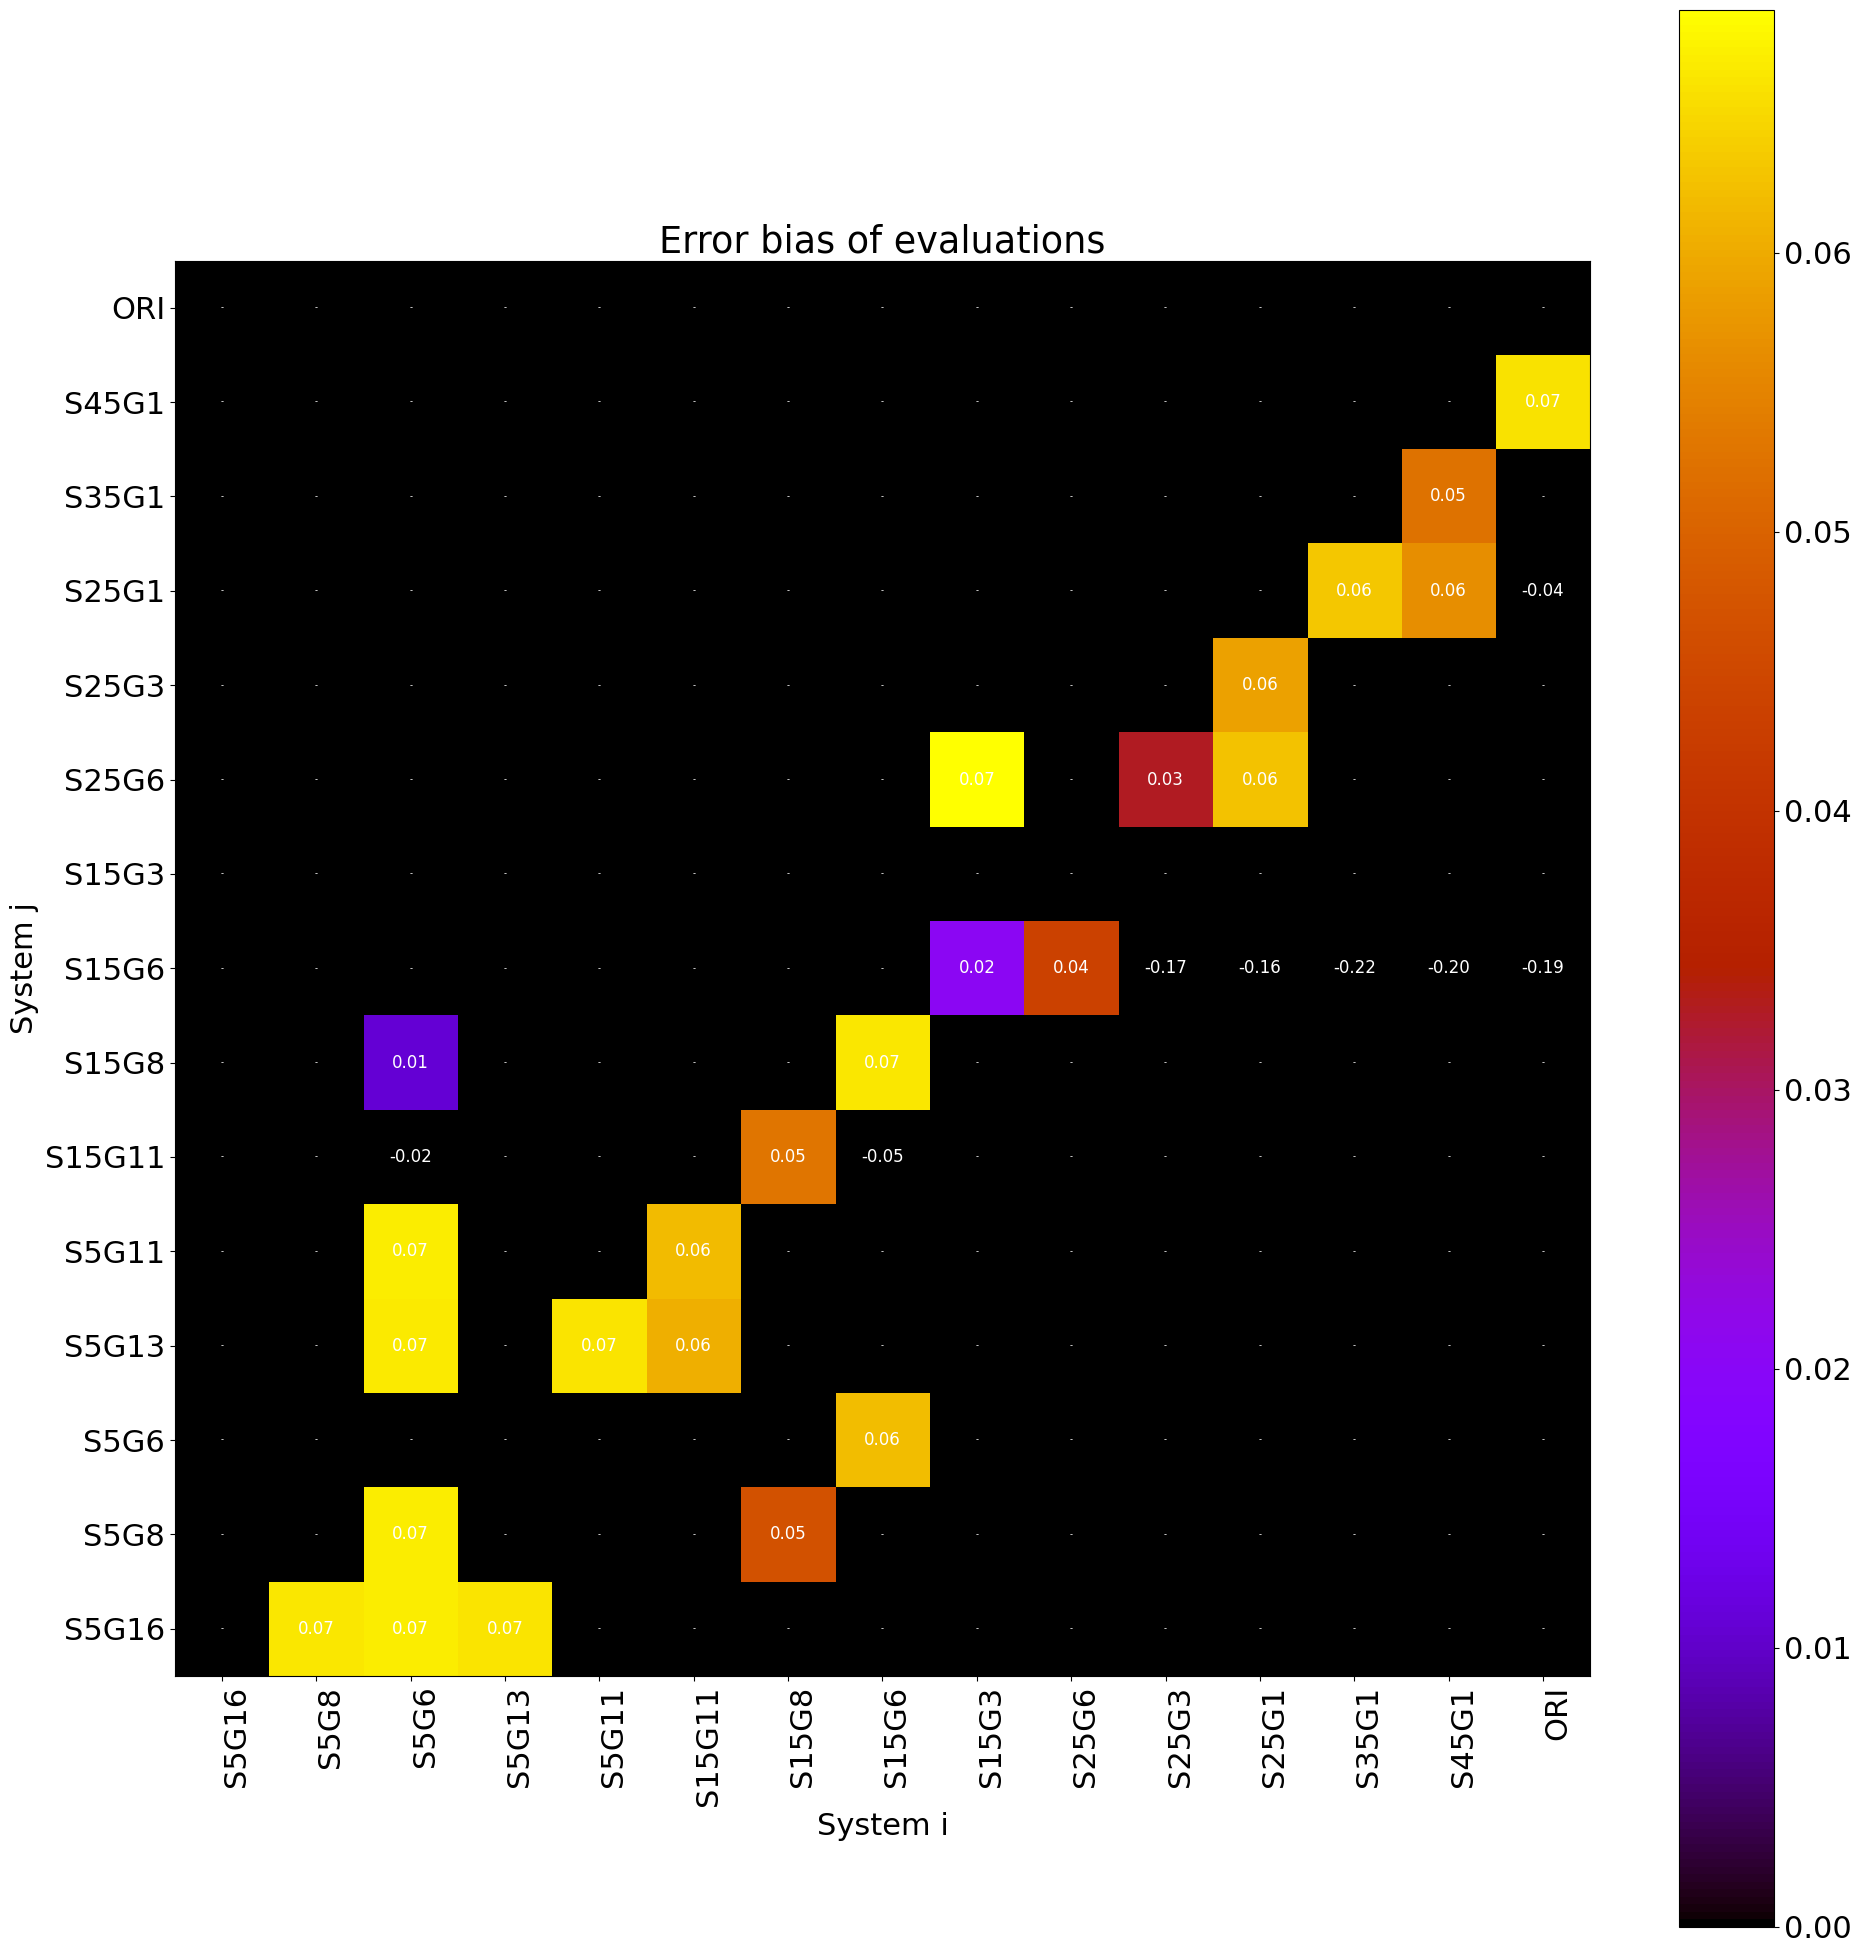

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(epsilon_map, origin="lower", cmap='gnuplot', vmin=0.0)
fig.colorbar(im, ax=ax)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(systems)))
ax.set_yticks(np.arange(len(systems)))
ax.set_xticklabels(systems)
ax.set_yticklabels(systems)
ax.set_xlabel('System i')
ax.set_ylabel('System j')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(systems)):
    for j in range(len(systems)):
        if (score_map[i, j] == 0):
            text = ax.text(j, i, '-',
                       ha="center", va="center", color="w", fontsize=6)
        else:
            text = ax.text(j, i, f"{epsilon_map[i, j]:0.2f}",
                       ha="center", va="center", color=fontcolor(epsilon_map[i, j], 0.1), fontsize=12)

ax.set_title("Error bias of evaluations")
fig.tight_layout()
plt.show()
fig.savefig('epsilon_merge_rank.pdf', bbox_inches="tight")
fig.savefig('epsilon_merge_rank.png', bbox_inches="tight", dpi=500)

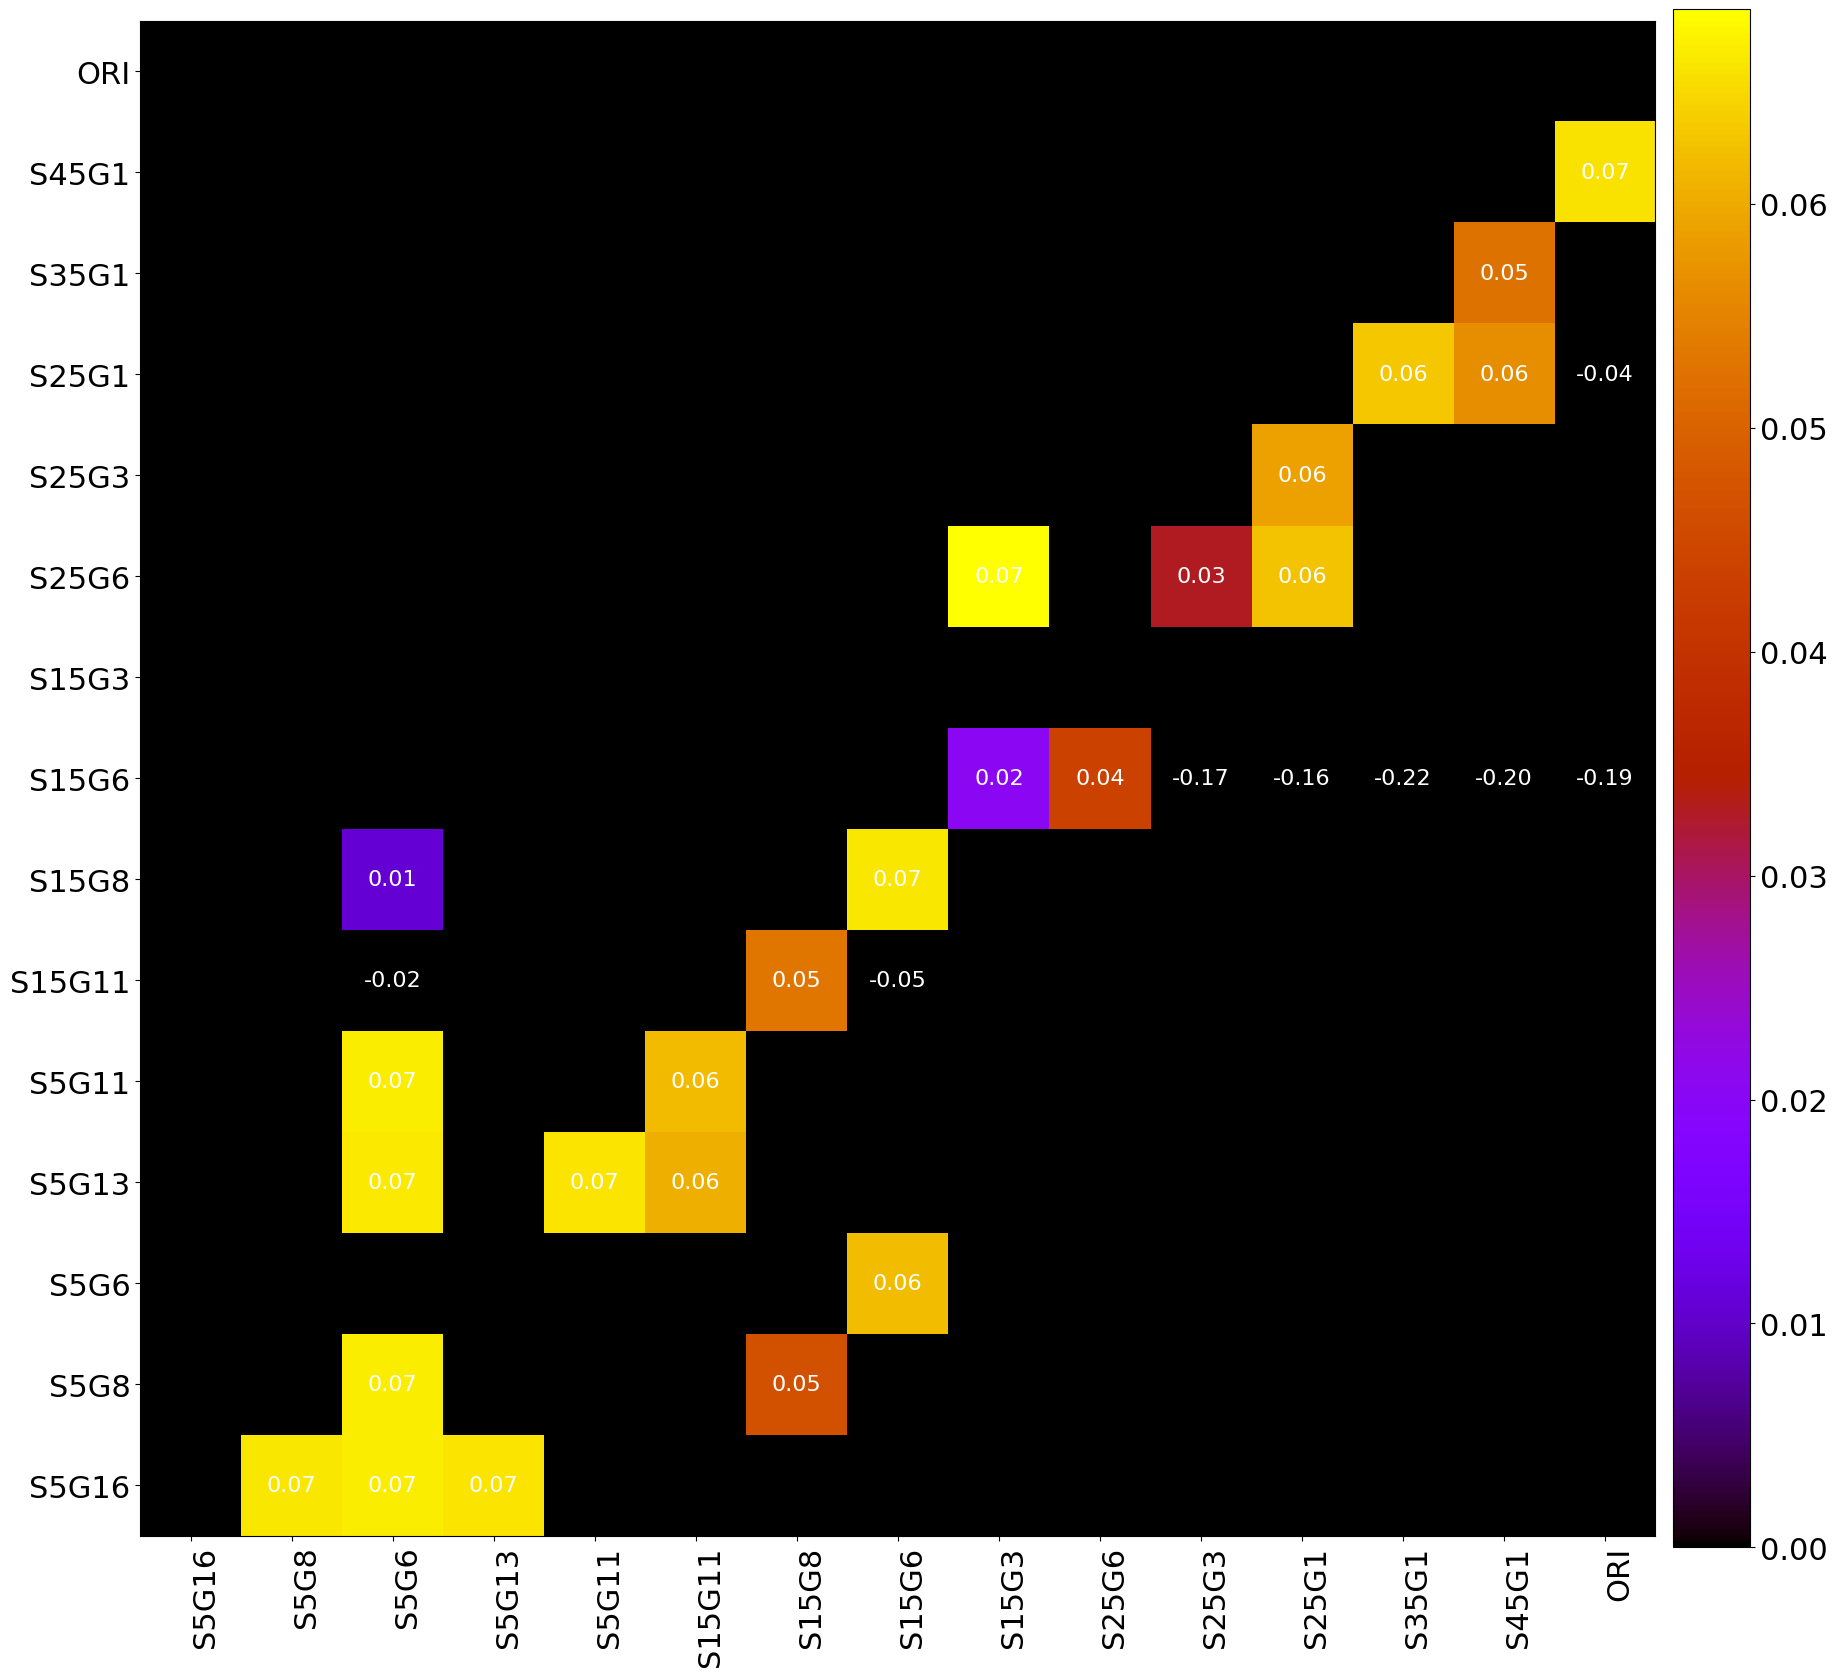

In [55]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(epsilon_map, origin="lower", cmap='gnuplot', vmin=0.0)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(systems)))
ax.set_yticks(np.arange(len(systems)))
ax.set_xticklabels([s for s in systems])
ax.set_yticklabels([s for s in systems])
# ax.set_xlabel('System i')
# ax.set_ylabel('System j')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(systems)):
    for j in range(len(systems)):
        if (score_map[i, j] == 0):
#             text = ax.text(j, i, '-',
#                        ha="center", va="center", color="w", fontsize=6)
            pass
        else:
            text = ax.text(j, i, f"{epsilon_map[i, j]:0.2f}",
                       ha="center", va="center", color=fontcolor(epsilon_map[i, j], 0.1), fontsize=16)

# ax.set_title("Error bias of evaluations")
fig.tight_layout()
plt.show()
fig.savefig('epsilon_merge_rank2.pdf', bbox_inches="tight")
fig.savefig('epsilon_merge_rank2.png', bbox_inches="tight", dpi=500)

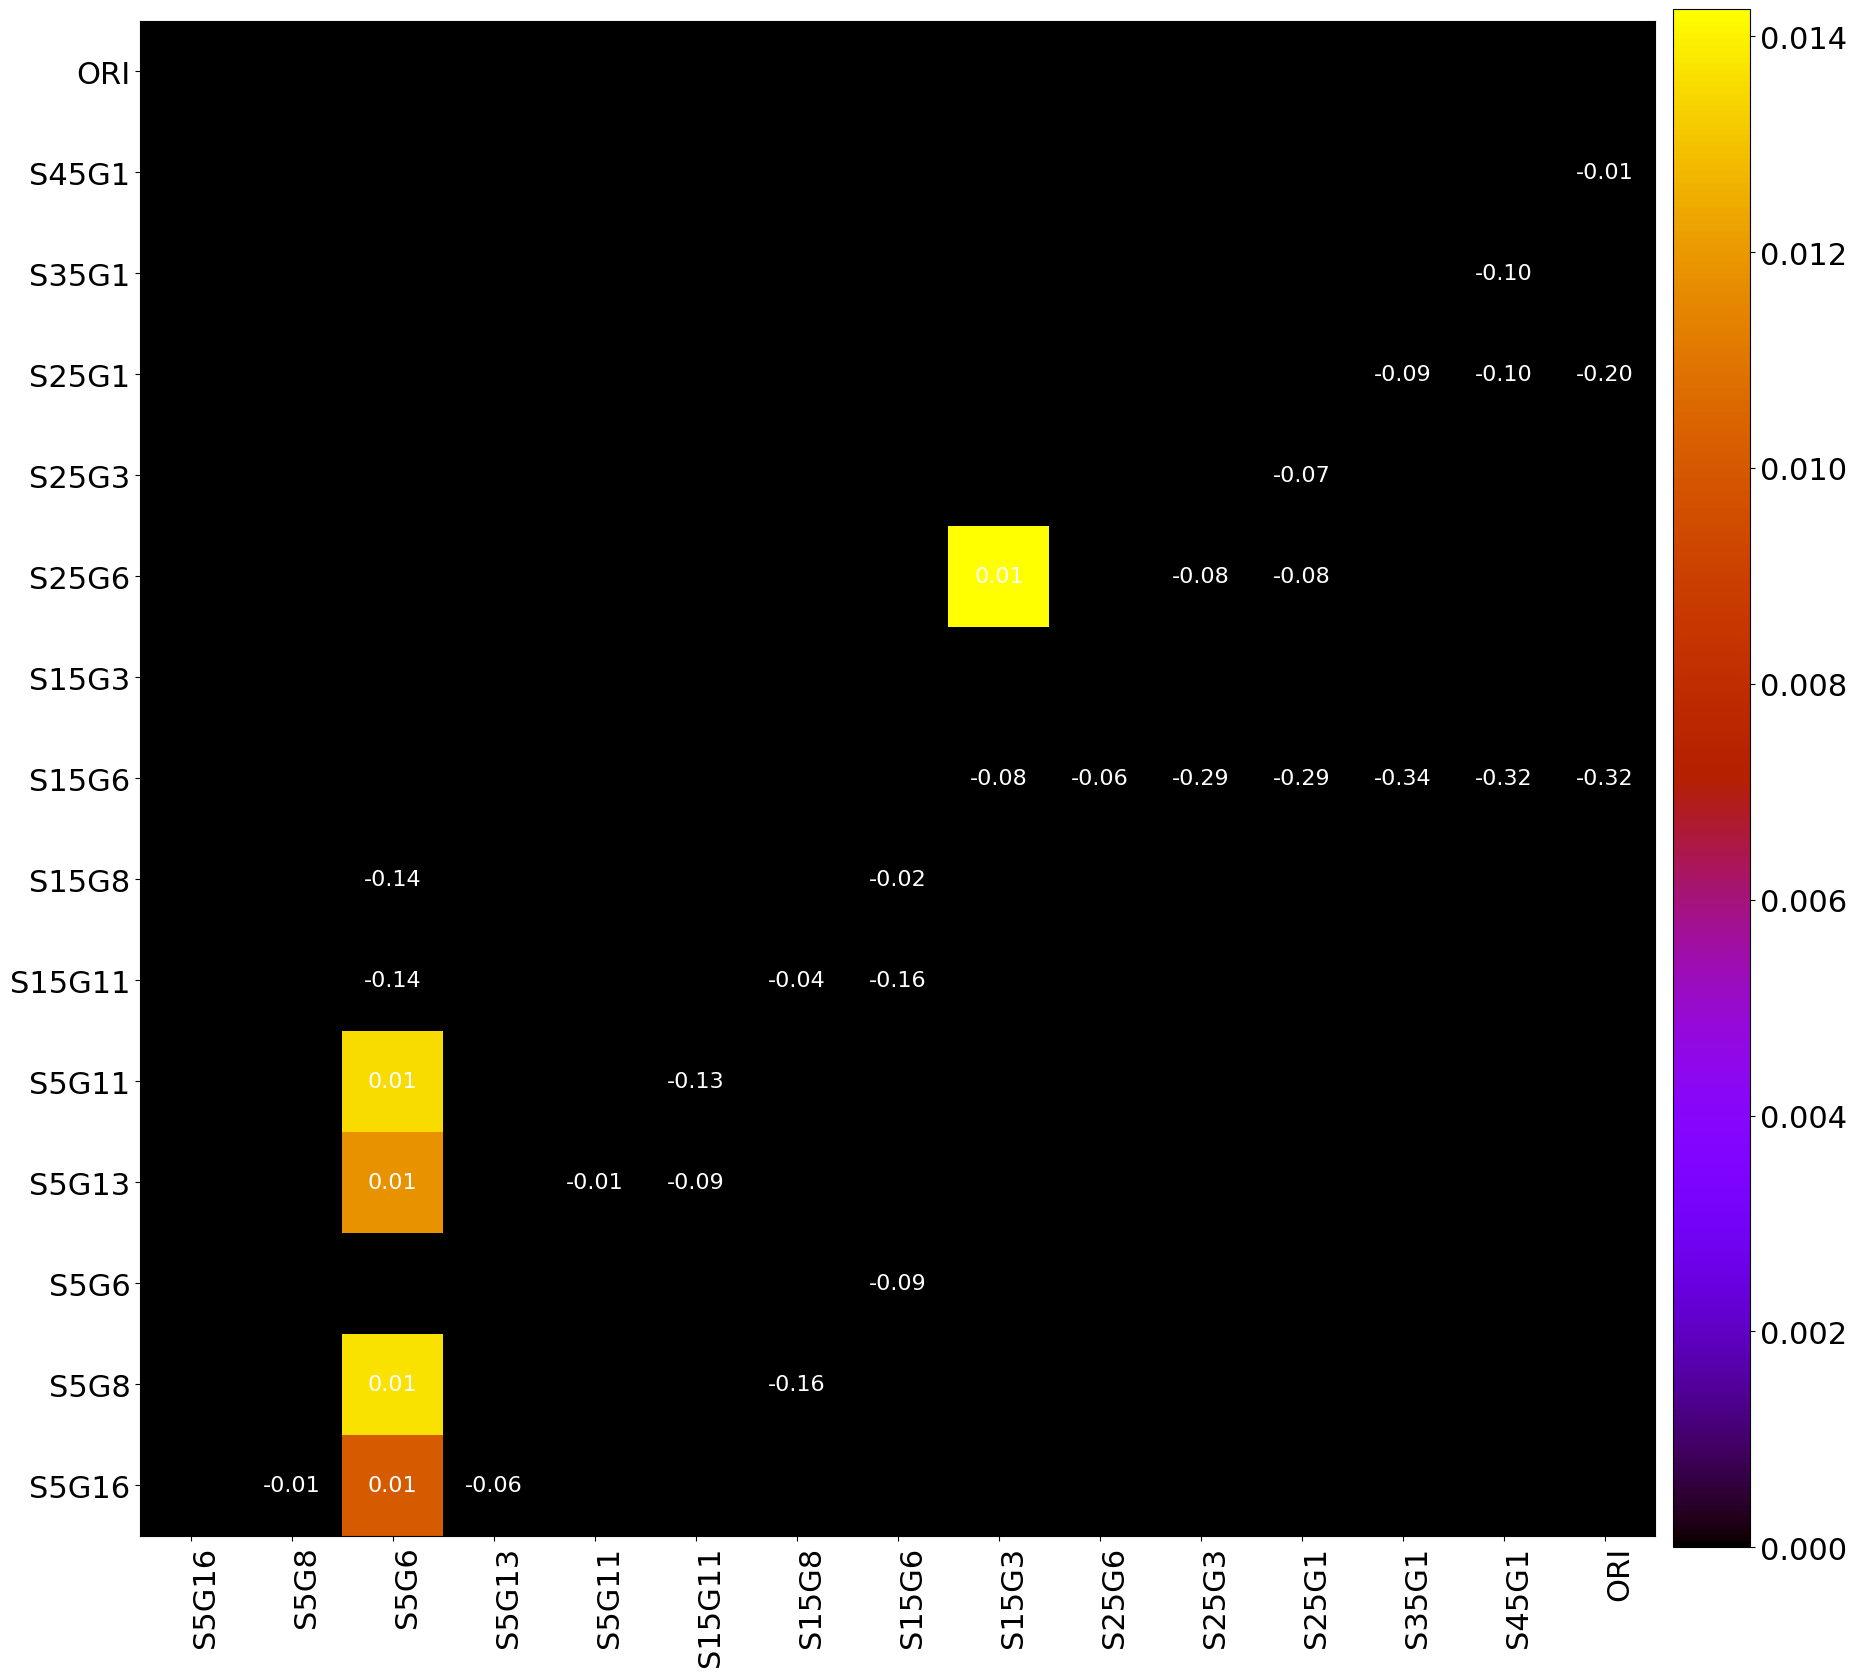

In [56]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(epsilonh_map, origin="lower", cmap='gnuplot', vmin=0.0)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(systems)))
ax.set_yticks(np.arange(len(systems)))
ax.set_xticklabels([s for s in systems])
ax.set_yticklabels([s for s in systems])
# ax.set_xlabel('System i')
# ax.set_ylabel('System j')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(systems)):
    for j in range(len(systems)):
        if (score_map[i, j] == 0):
#             text = ax.text(j, i, '-',
#                        ha="center", va="center", color="w", fontsize=6)
            pass
        else:
            text = ax.text(j, i, f"{epsilonh_map[i, j]:0.2f}",
                       ha="center", va="center", color=fontcolor(epsilon_map[i, j], 0.1), fontsize=16)

# ax.set_title("Error bias of evaluations")
fig.tight_layout()
plt.show()
fig.savefig('epsilonh_merge_rank2.pdf', bbox_inches="tight")
fig.savefig('epsilonh_merge_rank2.png', bbox_inches="tight", dpi=500)

In [57]:
np.max(epsilonh_map)

0.014251396

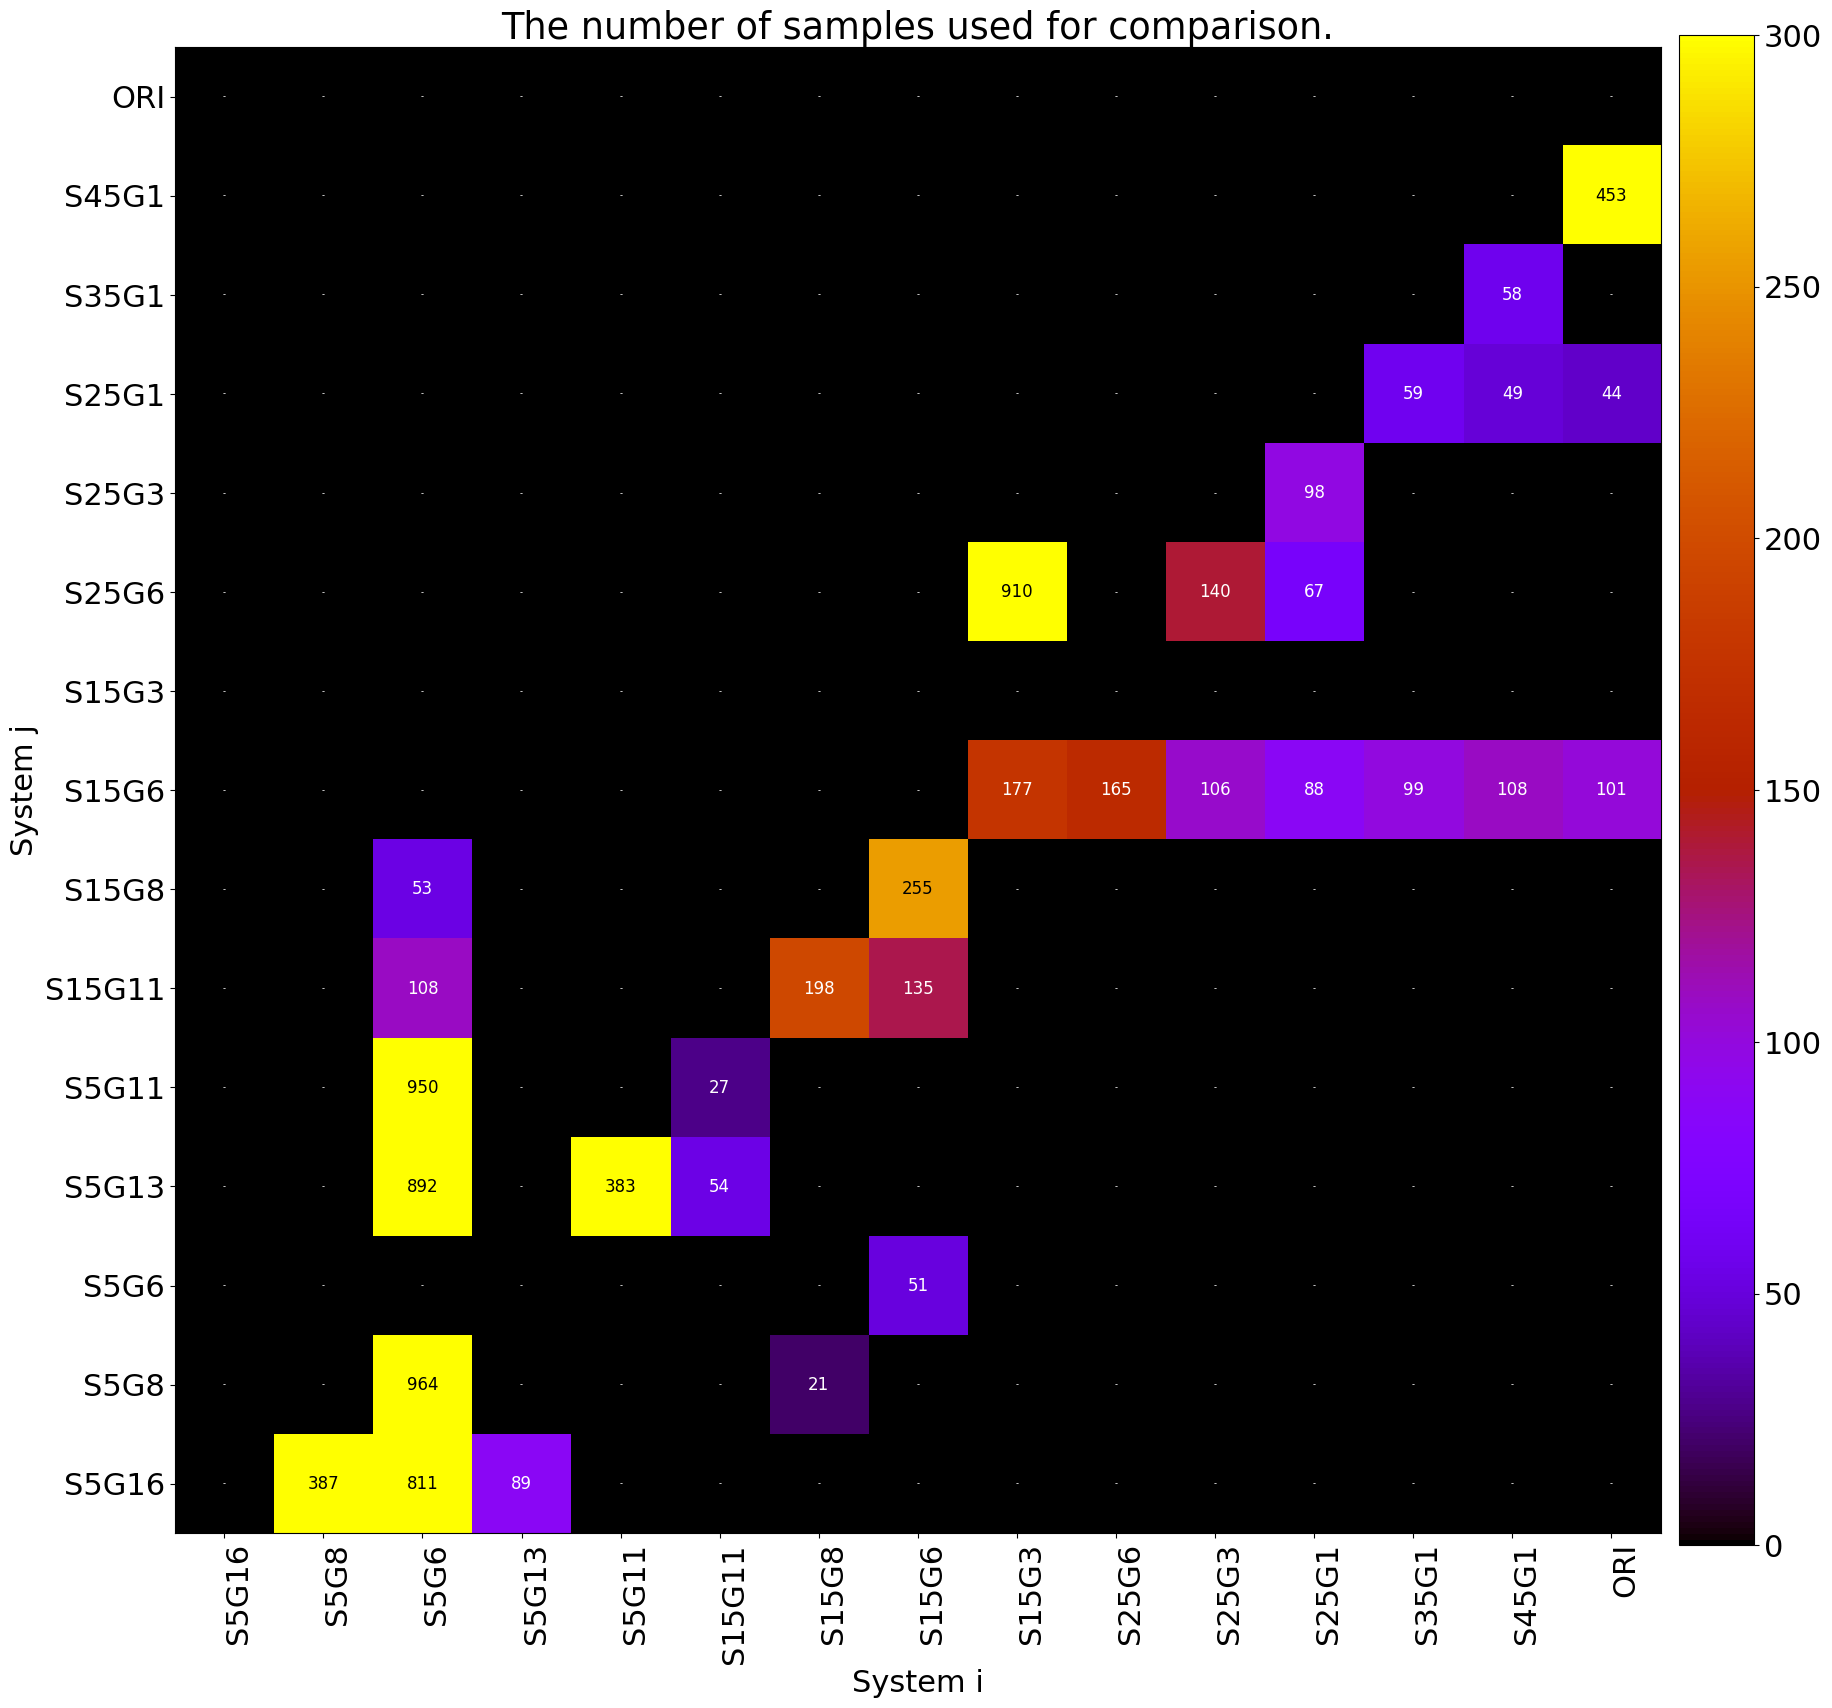

In [58]:
vmax = 300
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(result_map, origin="lower", cmap='gnuplot', vmin=0, vmax=vmax)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(systems)))
ax.set_yticks(np.arange(len(systems)))
ax.set_xticklabels(systems)
ax.set_yticklabels(systems)
ax.set_xlabel('System i')
ax.set_ylabel('System j')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(systems)):
    for j in range(len(systems)):
        if (i == j or result_map[i, j] == 0):
            text = ax.text(j, i, '-',
                       ha="center", va="center", color="w", fontsize=6)
        else:
            text = ax.text(j, i, result_map[i, j],
                       ha="center", va="center", color=fontcolor(result_map[i, j], vmax), fontsize=12)

ax.set_title("The number of samples used for comparison.")
fig.tight_layout()
plt.show()
fig.savefig('n_samples_merge_rank.pdf', bbox_inches="tight")
fig.savefig('n_samples_merge_rank.png', bbox_inches="tight", dpi=500)

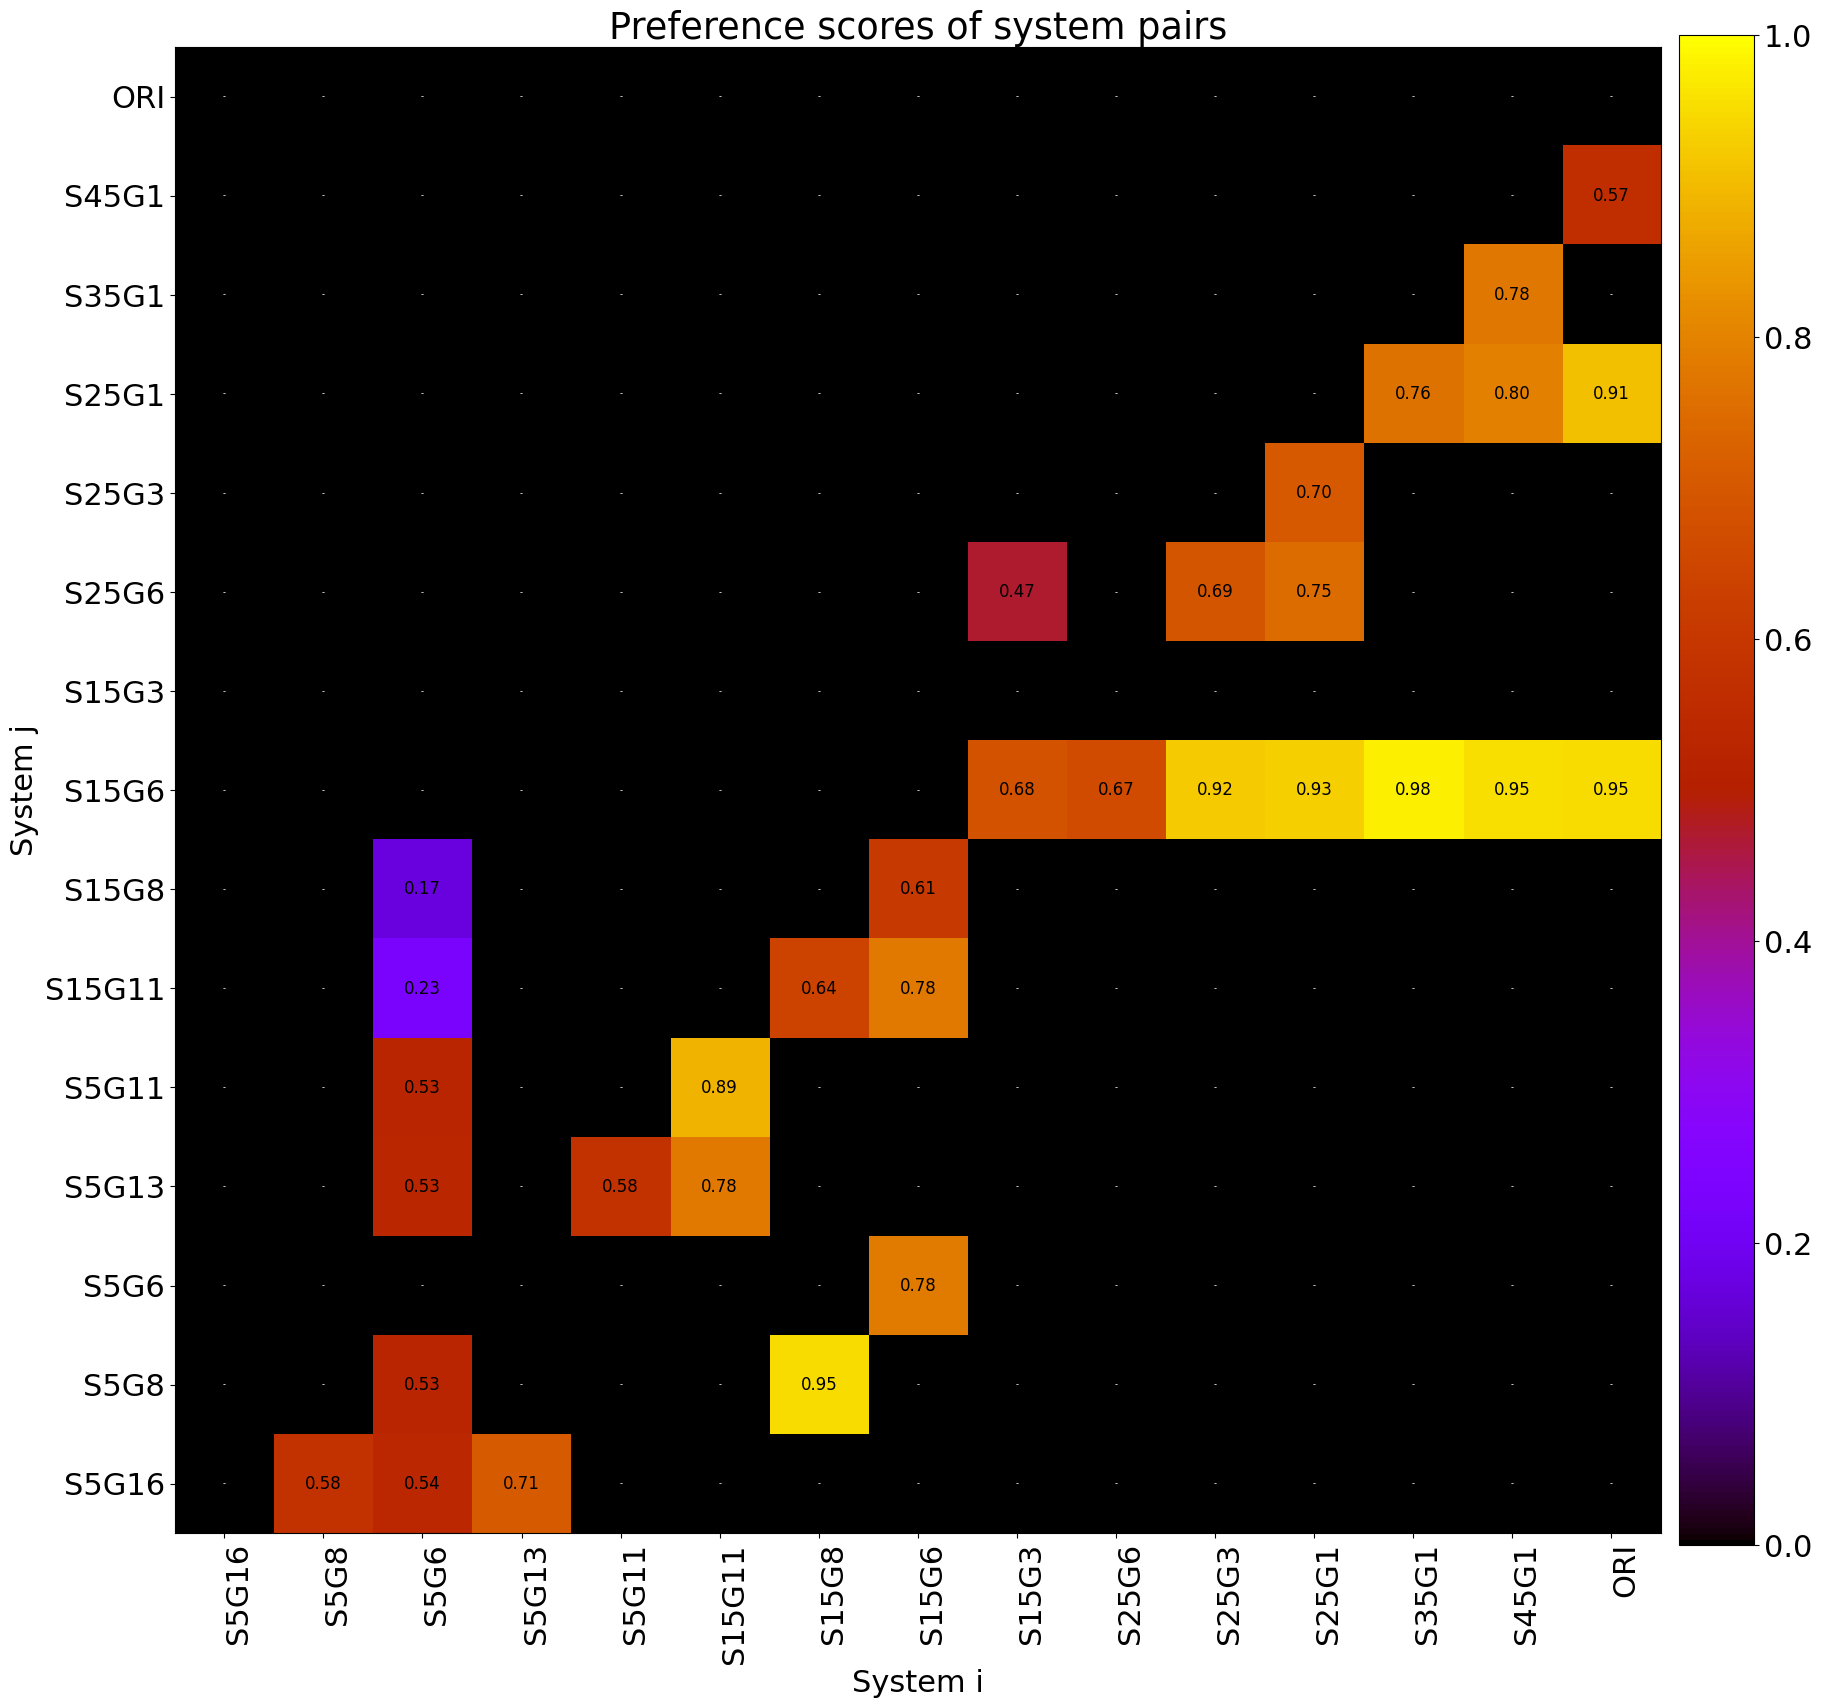

In [61]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(score_map, origin="lower", cmap='gnuplot', vmin=0.0, vmax=1.0)
fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(systems)))
ax.set_yticks(np.arange(len(systems)))
ax.set_xticklabels(systems)
ax.set_yticklabels(systems)
ax.set_xlabel('System i')
ax.set_ylabel('System j')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(systems)):
    for j in range(len(systems)):
        if (score_map[i, j] == 0):
            text = ax.text(j, i, '-',
                       ha="center", va="center", color="w", fontsize=6)
        else:
            text = ax.text(j, i, f"{score_map[i, j]:0.2f}",
                       ha="center", va="center", color=fontcolor(result_map[i, j], 1.0), fontsize=12)

ax.set_title("Preference scores of system pairs")
fig.tight_layout()
plt.show()
fig.savefig('score_merge_rank.pdf', bbox_inches="tight")
fig.savefig('score_merge_rank.png', bbox_inches="tight", dpi=500)

In [19]:
systems

['S5G16',
 'S5G8',
 'S5G6',
 'S5G13',
 'S5G11',
 'S15G11',
 'S15G8',
 'S15G6',
 'S15G3',
 'S25G6',
 'S25G3',
 'S25G1',
 'S35G1',
 'S45G1',
 'ORI']

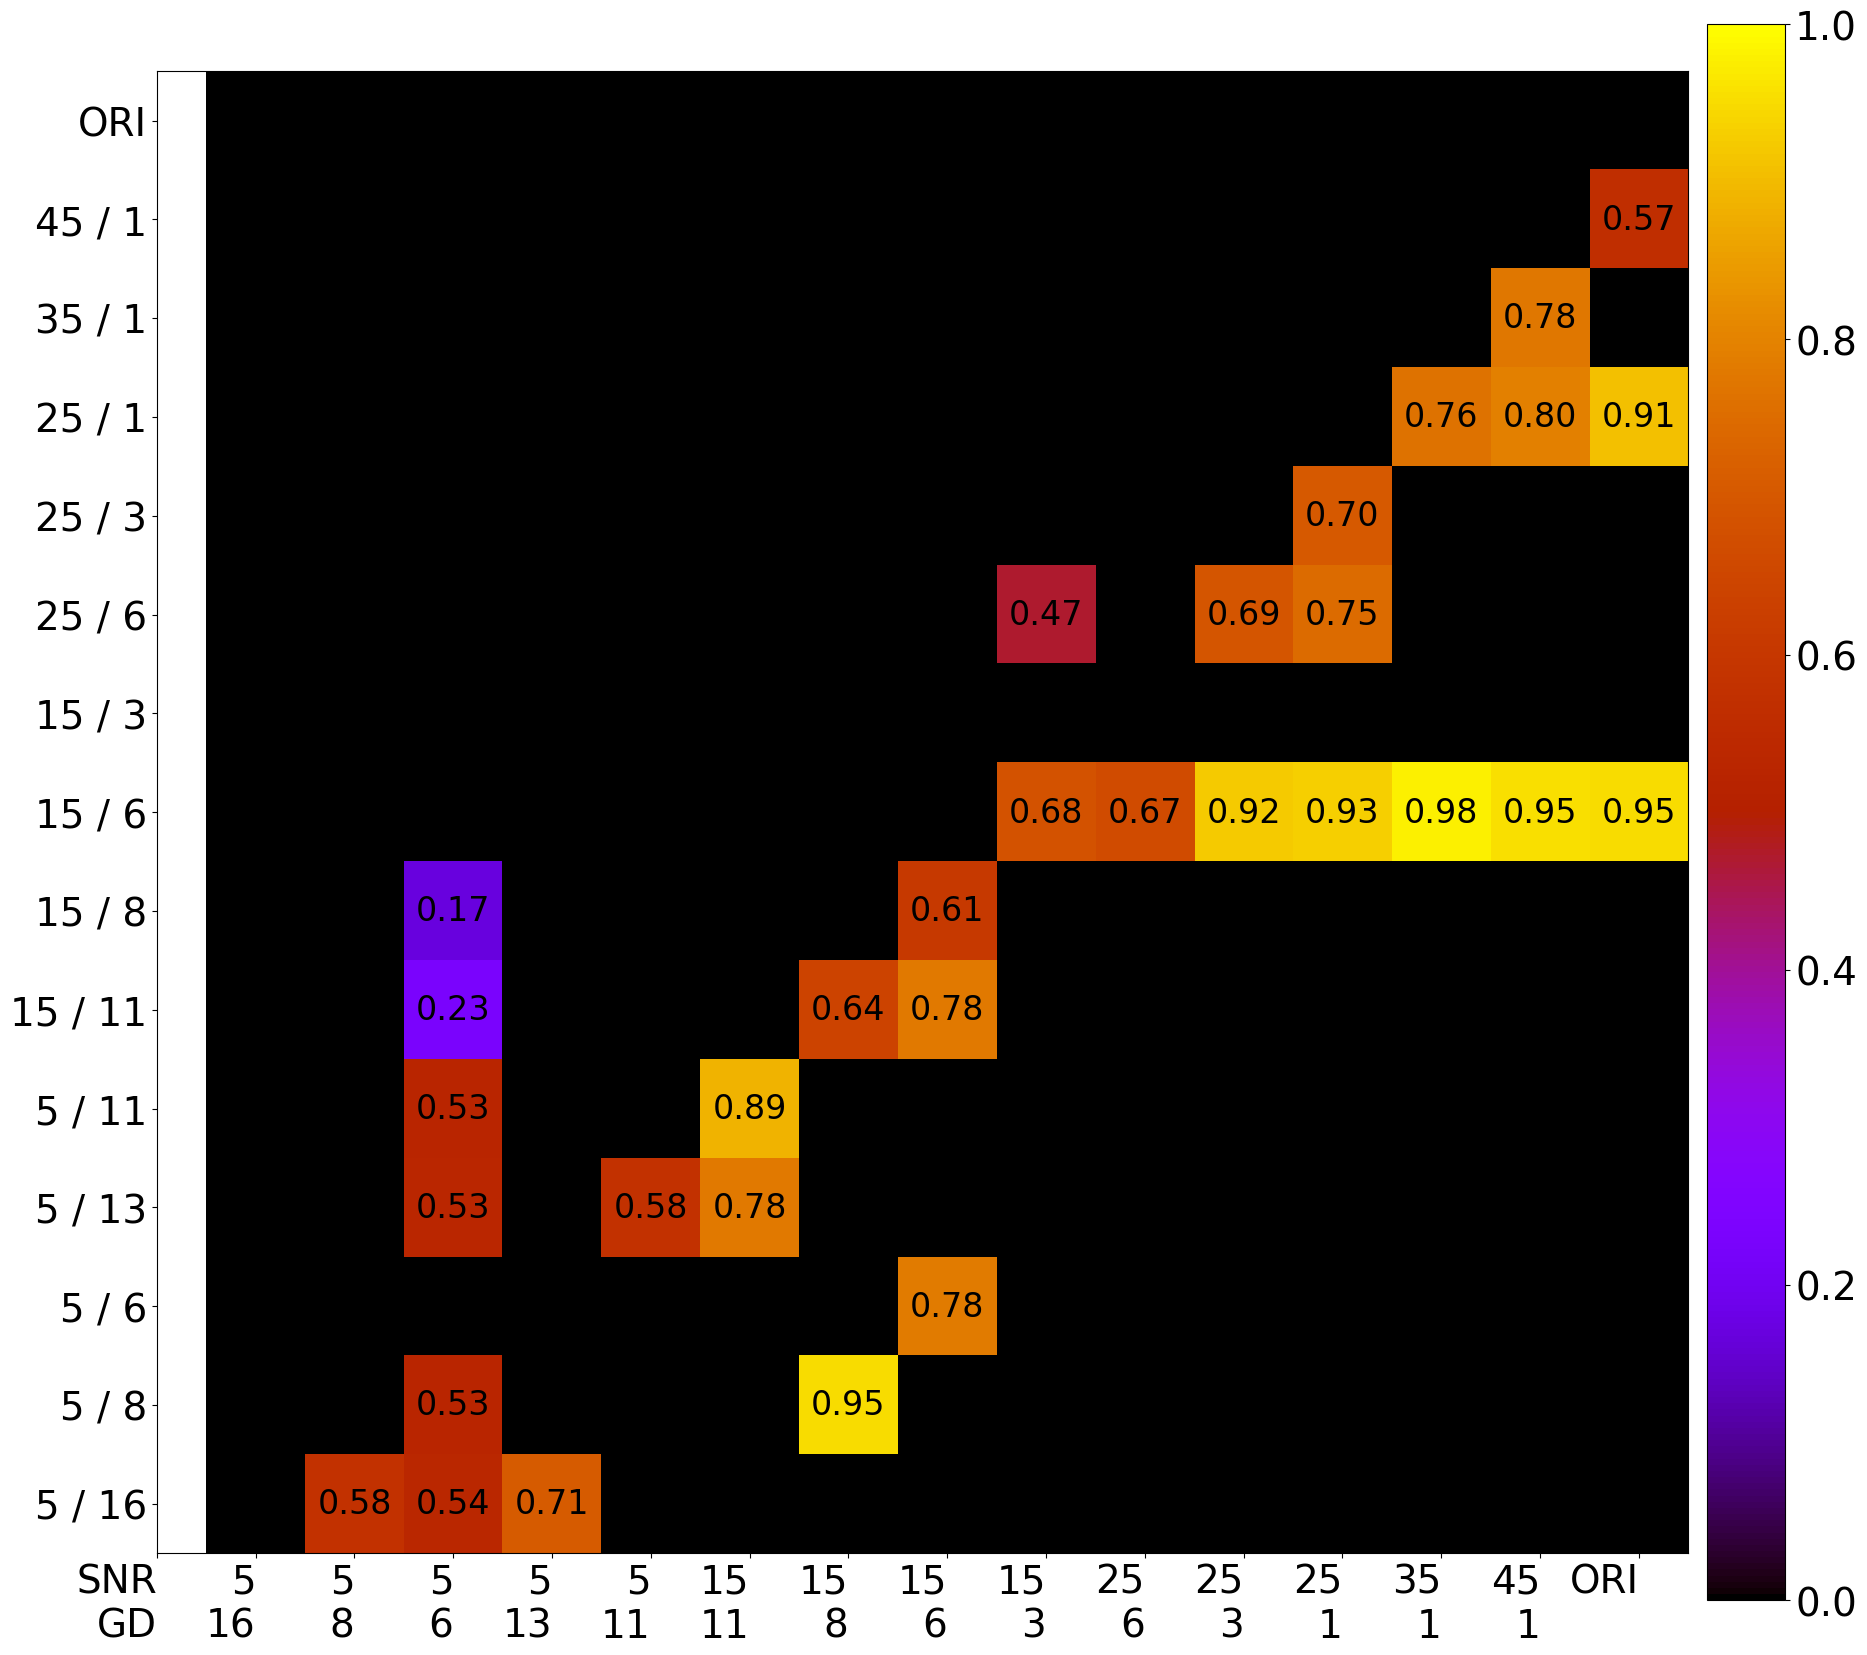

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))
im = ax.imshow(score_map, origin="lower", cmap='gnuplot', vmin=0.0, vmax=1.0)

fontsize = 28

cbar = fig.colorbar(im, ax=ax, shrink=0.8, pad=0.01)
cbar.ax.tick_params(labelsize=fontsize)

# Show all ticks and label them with the respective list entries
ax.set_xticks([-1] + list(range(len(systems))))
ax.set_yticks(np.arange(len(systems)))
ax.set_xticklabels(['SNR\nGD'] + [s.replace('S', '').replace('G', '\n') for s in systems], fontsize=fontsize)
ax.set_yticklabels([s.replace('S', '').replace('G', ' / ') for s in systems], fontsize=fontsize)
# ax.set_xlabel('System i')
# ax.set_ylabel('System j')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=0, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(systems)):
    for j in range(len(systems)):
        if (score_map[i, j] == 0):
#             text = ax.text(j, i, '-',
#                        ha="center", va="center", color="w", fontsize=6)
            pass
        else:
            text = ax.text(j, i, f"{score_map[i, j]:0.2f}",
                       ha="center", va="center", color=fontcolor(result_map[i, j], 1.0), fontsize=fontsize-4)

# ax.set_title("Preference scores of system pairs")
fig.tight_layout()
plt.show()
fig.savefig('score_merge_rank2.jpg', bbox_inches="tight")
fig.savefig('3-3.dce.pdf', bbox_inches="tight")